In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import itertools
import warnings
warnings.filterwarnings("ignore")

In [92]:
# Function to check stationarity using ADF test
def check_stationarity(ts, title=""):
    result = adfuller(ts.dropna())
    print(f"\nStationarity Test for {title}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1] < 0.05  # True if stationary (p < 0.05)

In [93]:
# Function to make data stationary if needed
def make_stationary(ts, title="", max_diff=2):
    diff_count = 0
    new_ts = ts.copy()
    while not check_stationarity(new_ts, f"{title} after {diff_count} diffs") and diff_count < max_diff:
        diff_count += 1
        new_ts = new_ts.diff().dropna()
        print(f"Applied differencing {diff_count} time(s)")
    return new_ts, diff_count

In [94]:
# Function to plot ACF and PACF
def plot_acf_pacf(ts, lags=20, title=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    acf_vals = acf(ts, nlags=lags)
    pacf_vals = pacf(ts, nlags=lags)
    ax1.plot(acf_vals); ax1.set_title(f"ACF - {title}")
    ax2.plot(pacf_vals); ax2.set_title(f"PACF - {title}")
    plt.show()

In [95]:
# Function to tune ARMA parameters using grid search
def tune_arma_parameters(ts, p_range, d_range, q_range):
    best_aic = float("inf")
    best_order = None
    for p, d, q in itertools.product(p_range, d_range, q_range):
        try:
            model = ARIMA(ts, order=(p, d, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
        except:
            continue
    print(f"Best ARMA order: {best_order}, AIC: {best_aic}")
    return best_order

In [111]:
# Function to fit ARMA model and forecast
def fit_arma_model(ts, p, d, q, forecast_steps):
    model = ARIMA(ts, order=(p, d, q))
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=forecast_steps)
    print(f"\nARMA({p},{d},{q}) Summary:\n{fitted_model.summary()}")
    return fitted_model, forecast

In [112]:
# Function to prepare data for RNN
def prepare_rnn_data(ts, look_back=10, forecast_steps=24):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(ts.values.reshape(-1, 1))
    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:i + look_back])
        y.append(scaled_data[i + look_back])
    X, y = np.array(X), np.array(y)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, y_train, X_test, y_test, scaler, scaled_data

In [113]:
# Function to build and train RNN model (LSTM or GRU)
def build_rnn_model(X_train, model_type="LSTM", look_back=10):
    model = Sequential()
    if model_type == "LSTM":
        model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(50))
    elif model_type == "GRU":
        model.add(GRU(50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(GRU(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    return model

In [114]:
# Function to forecast with RNN
def forecast_rnn(model, scaled_data, look_back, forecast_steps, scaler):
    last_sequence = scaled_data[-look_back:]
    forecast = []
    for _ in range(forecast_steps):
        pred = model.predict(last_sequence.reshape(1, look_back, 1), verbose=0)
        forecast.append(pred[0, 0])
        last_sequence = np.append(last_sequence[1:], pred)
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast

In [116]:
# Function to evaluate and plot results
def evaluate_and_plot(ts, forecast, model_name, title="", freq='M', forecast_steps=24):
    # Convert forecast to NumPy array if it's a pandas Series (ARMA) or keep as is (LSTM/GRU)
    forecast_array = forecast.values if isinstance(forecast, pd.Series) else forecast.flatten()

    # Ensure consistent lengths for evaluation
    if len(ts) >= forecast_steps:
        actual_for_comparison = ts[-forecast_steps:].values  # Convert Series to array
        forecast_for_comparison = forecast_array[:forecast_steps]  # Ensure length matches
        if len(actual_for_comparison) == len(forecast_for_comparison):
            rmse = np.sqrt(mean_squared_error(actual_for_comparison, forecast_for_comparison))
            mae = mean_absolute_error(actual_for_comparison, forecast_for_comparison)
        else:
            rmse, mae = np.nan, np.nan
            print(f"Warning: Length mismatch - Actual: {len(actual_for_comparison)}, Forecast: {len(forecast_for_comparison)}")
    else:
        rmse, mae = np.nan, np.nan
        print(f"Warning: Insufficient data ({len(ts)} points) to evaluate {forecast_steps}-step forecast for {title}")

    print(f"\n{model_name} Metrics for {title}:")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(ts, label="Actual")
    forecast_index = pd.date_range(start=ts.index[-1], periods=forecast_steps + 1, freq=freq)[1:]
    plt.plot(forecast_index, forecast_array[:forecast_steps], label=f"{model_name} Forecast", linestyle='--')
    plt.title(f"{title} - {model_name}")
    plt.legend()
    plt.show()

In [117]:
amazon = pd.read_csv("AMZN.csv")

In [118]:
amazon.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
1,2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2,2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
3,2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
4,2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


In [119]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [120]:
amazon['Date'] = pd.to_datetime(amazon['Date'])
amazon.set_index('Date', inplace=True)
amazon_ts = amazon['Close']

In [121]:
jj = pd.read_csv("jj.csv")

In [122]:
jj.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [123]:
jj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [124]:
jj['date'] = pd.to_datetime(jj['date'])
jj.set_index('date', inplace=True)
jj_ts = jj['data']

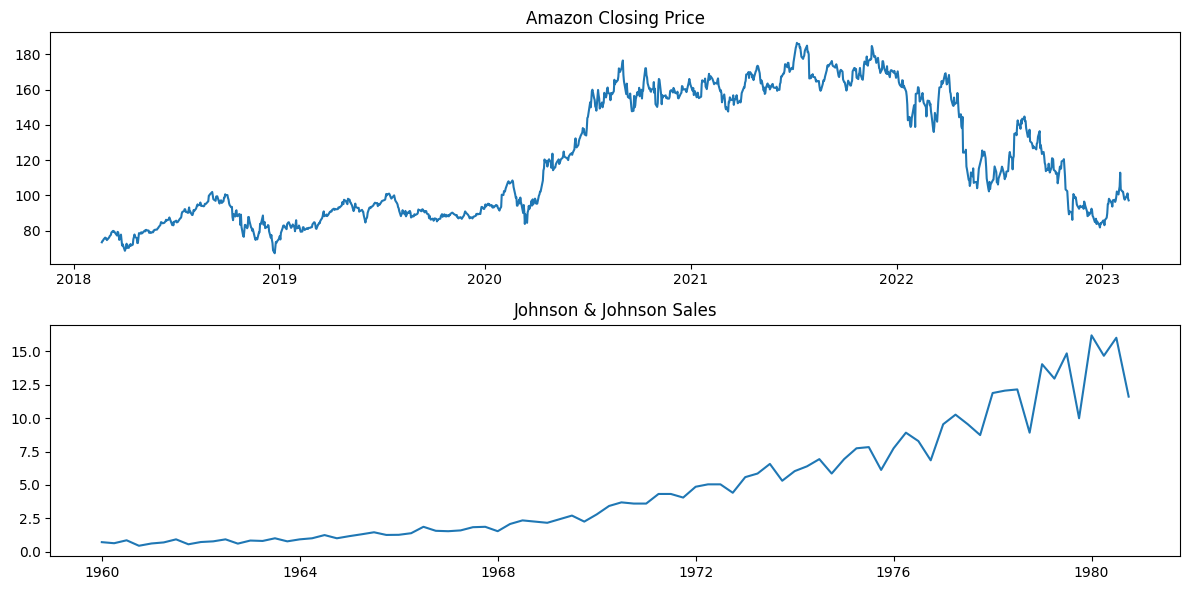

In [125]:
# Initial plots
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1); plt.plot(amazon_ts); plt.title("Amazon Closing Price")
plt.subplot(2, 1, 2); plt.plot(jj_ts); plt.title("Johnson & Johnson Sales")
plt.tight_layout()
plt.show()


=== Processing Amazon ===

Stationarity Test for Amazon:
ADF Statistic: -1.6578089913331728
p-value: 0.45297105465166737

Stationarity Test for Amazon after 0 diffs:
ADF Statistic: -1.6578089913331728
p-value: 0.45297105465166737
Applied differencing 1 time(s)

Stationarity Test for Amazon after 1 diffs:
ADF Statistic: -36.25077933242776
p-value: 0.0


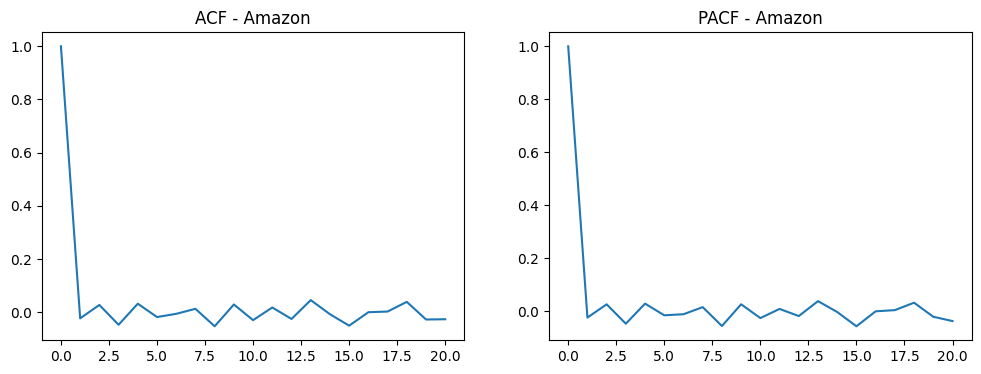

Best ARMA order: (2, 1, 2), AIC: 6122.315475889585

ARMA(2,1,2) Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3056.158
Date:                Wed, 09 Apr 2025   AIC                           6122.315
Time:                        15:00:27   BIC                           6148.002
Sample:                             0   HQIC                          6131.969
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6946      0.015   -111.813      0.000      -1.724      -1.665
ar.L2         -0.9604      0.015    -64.728      0.000    

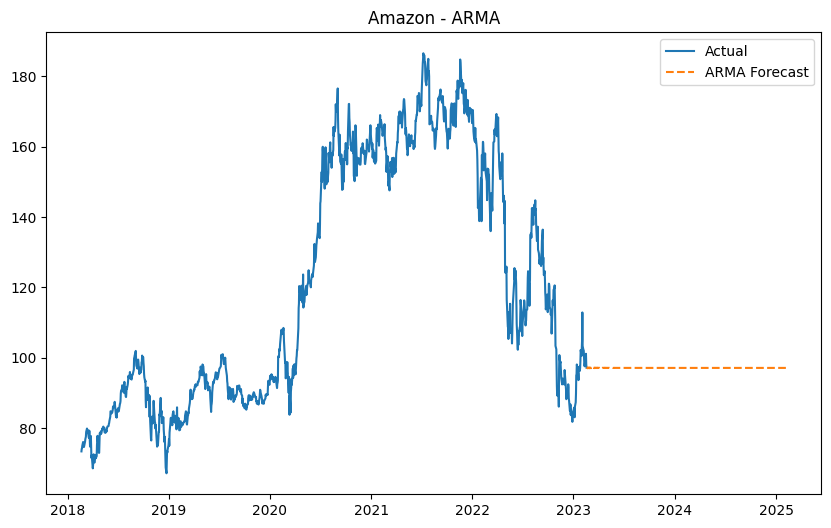


LSTM Metrics for Amazon:
RMSE: 38.2222, MAE: 35.3314


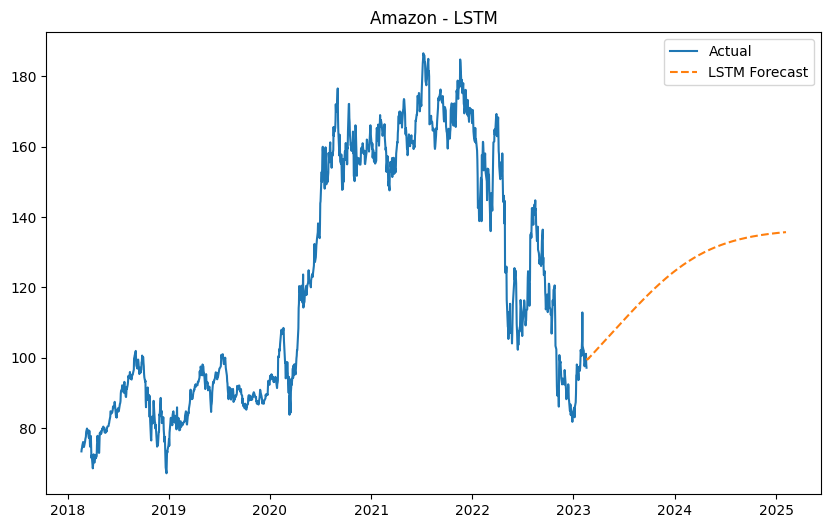


GRU Metrics for Amazon:
RMSE: 38.9849, MAE: 35.2318


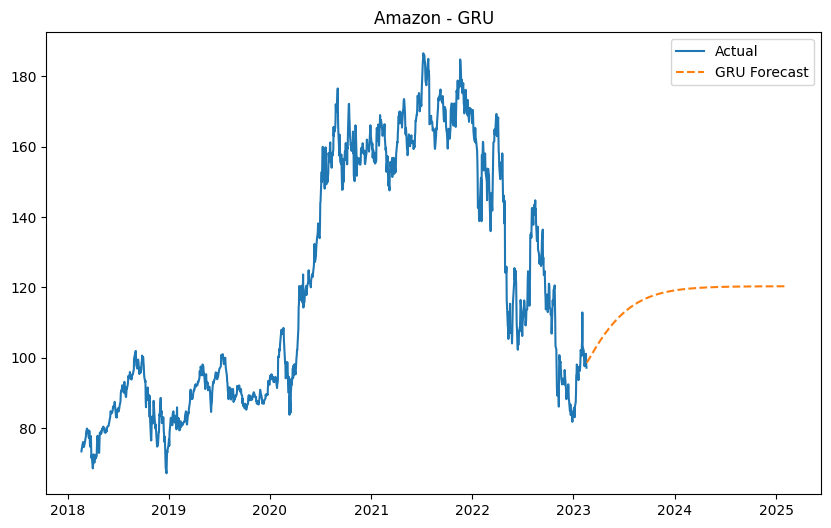


=== Processing Johnson & Johnson ===

Stationarity Test for Johnson & Johnson:
ADF Statistic: 2.7420165734574744
p-value: 1.0

Stationarity Test for Johnson & Johnson after 0 diffs:
ADF Statistic: 2.7420165734574744
p-value: 1.0
Applied differencing 1 time(s)

Stationarity Test for Johnson & Johnson after 1 diffs:
ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305
Applied differencing 2 time(s)

Stationarity Test for Johnson & Johnson after 2 diffs:
ADF Statistic: -3.585162874793155
p-value: 0.006051099869603682


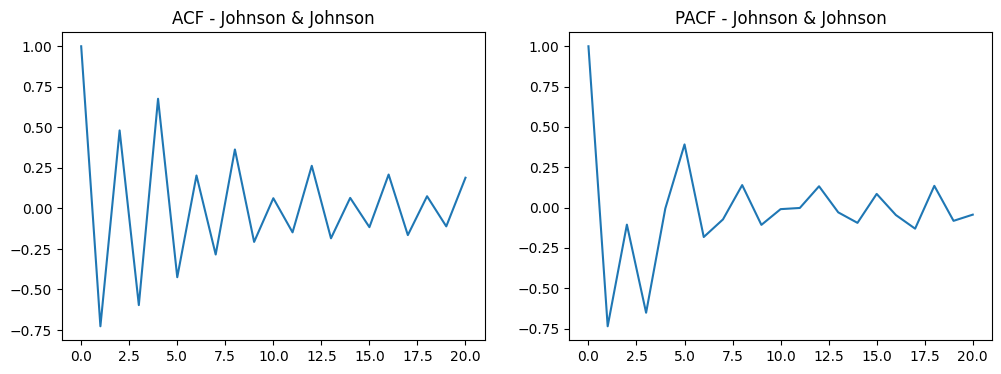

Best ARMA order: (0, 1, 2), AIC: 237.16719602271382

ARMA(0,1,2) Summary:
                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -115.584
Date:                Wed, 09 Apr 2025   AIC                            237.167
Time:                        15:02:45   BIC                            244.424
Sample:                             0   HQIC                           240.082
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3403      0.059    -22.887      0.000      -1.455      -1.226
ma.L2          0.9309      0.057     16.424      0.000   

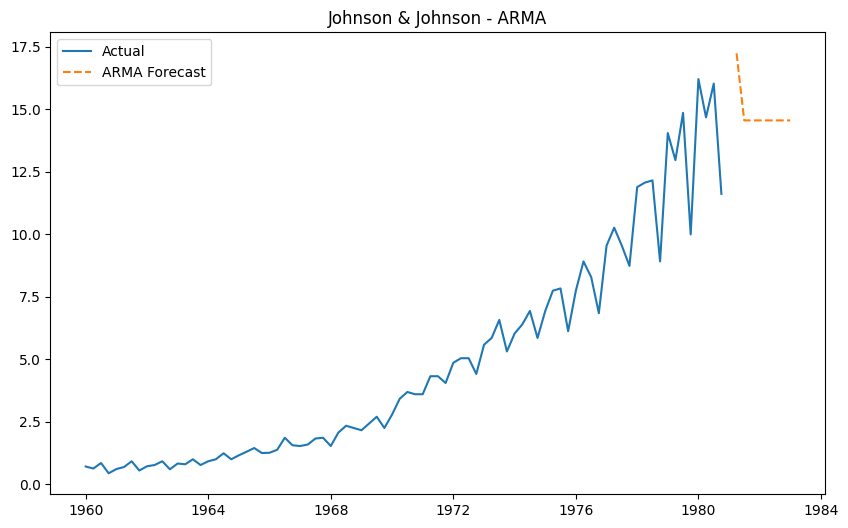


LSTM Metrics for Johnson & Johnson:
RMSE: 5.1662, MAE: 4.6025


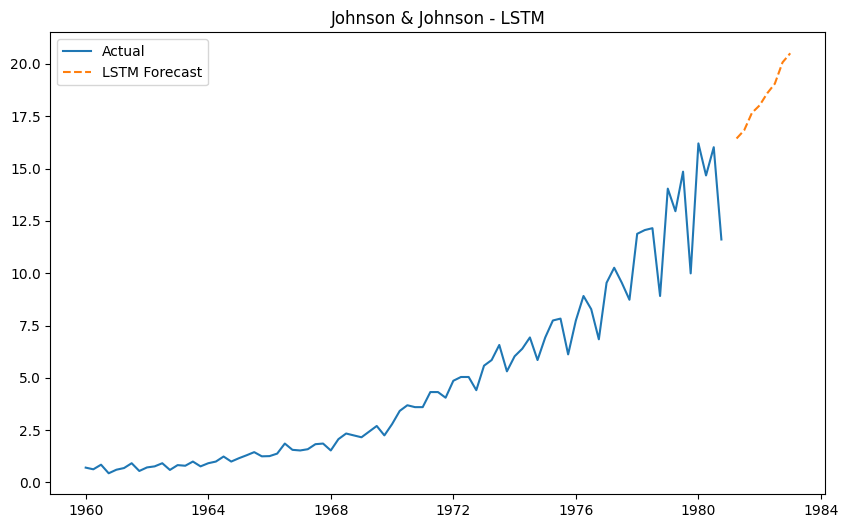


GRU Metrics for Johnson & Johnson:
RMSE: 4.2404, MAE: 3.5725


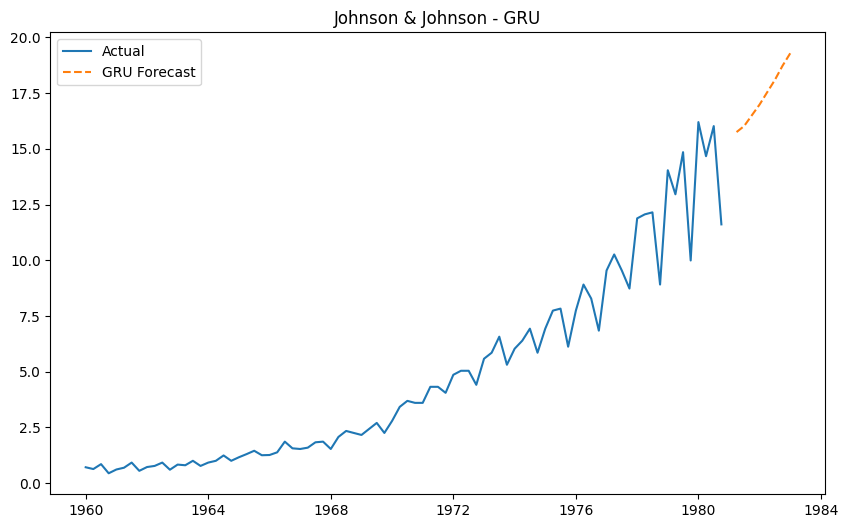

In [126]:
# Parameter ranges for ARMA tuning
p_range = range(0, 3)  # AR terms
d_range = range(0, 3)  # Differencing
q_range = range(0, 3)  # MA terms

# Process each dataset
for ts, name, freq in [(amazon_ts, "Amazon", 'D'), (jj_ts, "Johnson & Johnson", 'Q')]:
    print(f"\n=== Processing {name} ===")

    # Step 1: Stationarity check and transformation
    is_stationary = check_stationarity(ts, name)
    if not is_stationary:
        stationary_ts, d_initial = make_stationary(ts, title=name)
    else:
        stationary_ts, d_initial = ts, 0

    # Step 2: Plot ACF/PACF for parameter insights
    plot_acf_pacf(stationary_ts, title=name)

    # Step 3: Tune ARMA parameters
    best_order = tune_arma_parameters(ts, p_range, d_range, q_range)
    p, d, q = best_order

    # Step 4: Define forecast steps for 24 months based on frequency
    if name == "Amazon":  # Daily data: 24 months = ~720 days
        forecast_steps = 720  # 24 months * 30 days/month
    elif name == "Johnson & Johnson":  # Quarterly data: 24 months = 8 quarters
        forecast_steps = 8  # 24 months / 3 months per quarter

    # Step 5: Fit ARMA model and forecast
    arma_model, arma_forecast = fit_arma_model(ts, p, d, q, forecast_steps=forecast_steps)

    # Step 6: Build and forecast with LSTM
    X_train, y_train, X_test, y_test, scaler, scaled_data = prepare_rnn_data(ts, look_back=10, forecast_steps=forecast_steps)
    lstm_model = build_rnn_model(X_train, "LSTM")
    lstm_forecast = forecast_rnn(lstm_model, scaled_data, look_back=10, forecast_steps=forecast_steps, scaler=scaler)

    # Step 7: Build and forecast with GRU
    gru_model = build_rnn_model(X_train, "GRU")
    gru_forecast = forecast_rnn(gru_model, scaled_data, look_back=10, forecast_steps=forecast_steps, scaler=scaler)

    # Step 8: Evaluate and plot results
    evaluate_and_plot(ts, arma_forecast, "ARMA", name, freq=freq, forecast_steps=forecast_steps)
    evaluate_and_plot(ts, lstm_forecast, "LSTM", name, freq=freq, forecast_steps=forecast_steps)
    evaluate_and_plot(ts, gru_forecast, "GRU", name, freq=freq, forecast_steps=forecast_steps)